# 전형적인 양자컴퓨팅 프로그래밍 작업순서
1. Python Package들 설치
2. 수행에 필요한 import Packages
3. Quantum, Classical Register 만들기
4. 데이타입력 및 Quantum Register 초기화
5. 양자회로 작성 및 확인
6. 양자클라우드 플렛폼 접속환경 설정
7. 시뮬레이터 환경에서 수행: 에러없는 이상적인 값(확률) 확인
8. 실제 QPU 환경세서 수행: 에러있는 실제값(확률) 확인


**1. Python Package들 설치**


In [72]:
# git 소스코드 상에서 최신 버젼 설치(의존패키지 자동설치로 편리하지만, 버그가 있을 가능성 높음)
#!pip install git+https://github.com/qiskit-community/qiskit-braket-provider.git

#패키지 버젼이 매우 자주 업그레이트되므로 코드 안정성을 위해 사용하는 버젼을 명확히 지정하는 것이 바람직
!pip install qiskit-braket-provider==0.7.0
!pip install amazon-braket-sdk==1.104.1
#!python3 -m pip install boto3
#!python3 -m pip install botocore

KeyboardInterrupt: 

In [71]:
#설치된 주요 패키지 버젼 확인
%pip show qiskit
%pip show qiskit-braket-provider
%pip show amazon-braket-sdk

Name: qiskit
Version: 2.2.3
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: dill, numpy, rustworkx, scipy, stevedore, typing-extensions
Required-by: qiskit-ionq, qiskit_braket_provider
Name: qiskit_braket_provider
Version: 0.7.0
Summary: Qiskit-Braket provider to execute Qiskit programs on AWS quantum computing hardware devices through Amazon Braket.
Home-page: 
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: amazon-braket-sdk, certifi, numpy, qiskit, qiskit-ionq, setuptools
Required-by: 
Name: amazon-braket-sdk
Version: 1.104.1
Summary: An open source library for interacting with quantum computing devices on Amazon Braket
Home-page: https://github.com/amazon-braket/a

In [ ]:
#Python 수행 시 경고메세지 출력을 줄이는 코드
import warnings
warnings.filterwarnings('ignore')

In [15]:
#Amazon Braket SDK(QDK)의 실험기능 Enable
from braket.experimental_capabilities import EnableExperimentalCapability

In [16]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

**2. 수행에 필요한 import Packages**

In [17]:
from qiskit import QuantumCircuit

**3. Quantum, Classical Register 만들기**

In [18]:
# 양자 회로 생성
circuit = QuantumCircuit(5, 5)  # 5개의 양자 비트와 5개의 클래식 비트를 사용합니다.

**4. 데이타입력 및 Quantum Register 초기화**

In [19]:
#circuit.reset([0,1,2,3,4]) ###Amazon Braket SV1 Simulator에서 .reset() 메소드지원하지 못해서 주석처리

# 입력 비트 설정 (A=1, B=1)
circuit.x(0)  # A 비트를 1로 설정
circuit.x(1)  # B 비트를 1로 설정
circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=5, num_clbits=0, params=[]), qubits=(<Qubit register=(5, "q"), index=0>, <Qubit register=(5, "q"), index=1>, <Qubit register=(5, "q"), index=2>, <Qubit register=(5, "q"), index=3>, <Qubit register=(5, "q"), index=4>), clbits=())

**5. 양자회로 작성 및 확인**

In [20]:
# 반-가산기 회로 구현
circuit.cx(0, 3) # XOR 게이트 (A와 B의 논리합)
circuit.cx(1, 3) # XOR 게이트 (A와 B의 논리합)
circuit.ccx(0, 1, 4) # AND 게이트 (A와 B의 논리곱)
circuit.cx(2, 3) # XOR 게이트 (A와 B의 논리합)
circuit.ccx(0, 2, 4) # AND 게이트 (A와 B의 논리곱)
circuit.ccx(1, 2, 4) # AND 게이트 (A와 B의 논리곱)
circuit.barrier()

# 결과를 측정하여 Sum과 Carry 출력을 얻습니다.
circuit.measure(0, 4)  # 큐비트를 클래식 비트 4에 매핑
circuit.measure(1, 3)  # 큐비트를 클래식 비트 3에 매핑
circuit.measure(2, 2)  # 보조비트를 클래식 비트 2에 매핑
circuit.measure(3, 1)  # Sum(Result) 비트를 클래식 비트 1에 매핑
circuit.measure(4, 0)  # Carry 비트를 클래식 비트 0에 매핑


In [73]:
#작성된 양자회로 구조 확인
circuit.draw()

┌───┐ ░                                ░ ┌─┐            
q_0: ┤ X ├─░───■─────────■─────────■────────░─┤M├────────────
     ├───┤ ░   │         │         │        ░ └╥┘┌─┐         
q_1: ┤ X ├─░───┼────■────■─────────┼────■───░──╫─┤M├─────────
     └───┘ ░   │    │    │         │    │   ░  ║ └╥┘┌─┐      
q_2: ──────░───┼────┼────┼────■────■────■───░──╫──╫─┤M├──────
           ░ ┌─┴─┐┌─┴─┐  │  ┌─┴─┐  │    │   ░  ║  ║ └╥┘┌─┐   
q_3: ──────░─┤ X ├┤ X ├──┼──┤ X ├──┼────┼───░──╫──╫──╫─┤M├───
           ░ └───┘└───┘┌─┴─┐└───┘┌─┴─┐┌─┴─┐ ░  ║  ║  ║ └╥┘┌─┐
q_4: ──────░───────────┤ X ├─────┤ X ├┤ X ├─░──╫──╫──╫──╫─┤M├
           ░           └───┘     └───┘└───┘ ░  ║  ║  ║  ║ └╥┘
c: 5/══════════════════════════════════════════╩══╩══╩══╩══╩═
                                               4  3  2  1  0

**6. 양자클라우드 플렛폼 접속환경 설정**

In [79]:
#양자클라우드를 접속하기 위한 Access-Key, Secret_Access_key설정, Github에 공개되지 않토록 주의하세요.
#작업시간이 길어지면 아래 키들은 작업환경의 운영체제(O/S, windows, Mac, Linux)의 환경변수에 넣어서 읽어내는 것이 바람직
import os
# Set environment variables for AWS credentials
os.environ['AWS_ACCESS_KEY_ID'] = ""
os.environ['AWS_SECRET_ACCESS_KEY'] = ""
os.environ['AWS_DEFAULT_REGION'] = "us-east-1"

In [ ]:
#import os

#aws_access_key_id = os.environ.get('AWS_ACCESS_KEY_ID')
#aws_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')
#aws_default_region = os.environ.get('AWS_DEFAULT_REGION', 'us-east-1') # Default region if not set

#if aws_access_key_id: os.environ['AWS_ACCESS_KEY_ID'] = aws_access_key_id
#if aws_secret_access_key: os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_access_key
#os.environ['AWS_DEFAULT_REGION'] = aws_default_region

In [80]:
#노트북, 서버, VM에 설치된 Local Simulator사용시 아래 부분 사용

#from qiskit_braket_provider import BraketLocalBackend

#local_simulator = BraketLocalBackend()
#local_sv_simulator = BraketLocalBackend(name='braket_sv')
#local_dm_simulator = BraketLocalBackend(name='braket_dm')

In [23]:
from qiskit_braket_provider import BraketProvider

provider = BraketProvider()
#provider.backends(statuses=["ONLINE"], types=["SIMULATOR"])
#provider.backends(statuses=["ONLINE"], types=["QPU"])
provider.backends(statuses=["ONLINE"], types=["SIMULATOR", "QPU"])

[BraketBackend[Ankaa-3],
 BraketBackend[Emerald],
 BraketBackend[Forte 1],
 BraketBackend[Garnet],
 BraketBackend[SV1],
 BraketBackend[TN1],
 BraketBackend[dm1]]

**7. 시뮬레이터 환경에서 수행: 에러없는 이상적인 값(확률) 확인**

In [24]:
backend = provider.get_backend("SV1")
#backend = provider.get_backend("dm1")
#backend = provider.get_backend("TN1")

In [75]:
from qiskit.compiler import transpile

#플렛폼 의존적인 회로로 변형을 확인, 예전의 컴파일과정과 같음
trans_qc = transpile(circuit, backend)
trans_qc.draw()

┌───┐ ░                                ░             ┌─┐
q_0: ┤ X ├─░───■─────────■─────────■────────░─────────────┤M├
     ├───┤ ░   │         │         │        ░          ┌─┐└╥┘
q_1: ┤ X ├─░───┼────■────■─────────┼────■───░──────────┤M├─╫─
     └───┘ ░   │    │    │         │    │   ░       ┌─┐└╥┘ ║ 
q_2: ──────░───┼────┼────┼────■────■────■───░───────┤M├─╫──╫─
           ░ ┌─┴─┐┌─┴─┐  │  ┌─┴─┐  │    │   ░    ┌─┐└╥┘ ║  ║ 
q_3: ──────░─┤ X ├┤ X ├──┼──┤ X ├──┼────┼───░────┤M├─╫──╫──╫─
           ░ └───┘└───┘┌─┴─┐└───┘┌─┴─┐┌─┴─┐ ░ ┌─┐└╥┘ ║  ║  ║ 
q_4: ──────░───────────┤ X ├─────┤ X ├┤ X ├─░─┤M├─╫──╫──╫──╫─
           ░           └───┘     └───┘└───┘ ░ └╥┘ ║  ║  ║  ║ 
c: 5/══════════════════════════════════════════╩══╩══╩══╩══╩═
                                               0  1  2  3  4

In [55]:
from qiskit.providers.jobstatus import JobStatus
import time

#양자클라우드로 양자회로를 잡형태로 제출 후 수행
job = backend.run(trans_qc, shots=1024)

print("Job ID is", job.job_id(),"\n")

# 제출된 잡에 대한 지속적인 실행 상태 확인
#while job.status() is not JobStatus.DONE:
#	print("Job status is", job.status() )
#	time.sleep(2)
###while

/usr/local/lib/python3.12/dist-packages/qiskit_braket_provider/providers/adapter.py:593: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn("The Qiskit circuit contains barrier instructions that are ignored.")


Job ID is arn:aws:braket:us-east-1:772420518916:quantum-task/de8bc79f-31fd-4671-acdd-92f1c8d773ce 



In [56]:
#양자클라우드 상의 잡 수행상태를 확인
print("Job status is", job.status() )

Job status is JobStatus.DONE


In [ ]:
# 중간에 세션이 종료된 경우 기존에 실행이 완료된 Job을 복구하는 방법
#job = backend.retrieve_job("arn:aws:braket:us-east-1:746669231099:quantum-task/f6fab6be-1590-4da0-914a-fade74efc485")

In [57]:
#수행이 완료되면 결과를 확인
result = job.result()
result

Result(backend_name='SV1', backend_version='2', job_id='arn:aws:braket:us-east-1:772420518916:quantum-task/de8bc79f-31fd-4671-acdd-92f1c8d773ce', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'10011': 1024}, memory=['10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '10011', '1001

In [58]:
# 결과 출력
counts = result.get_counts()
print(counts)

{'10011': 1024}


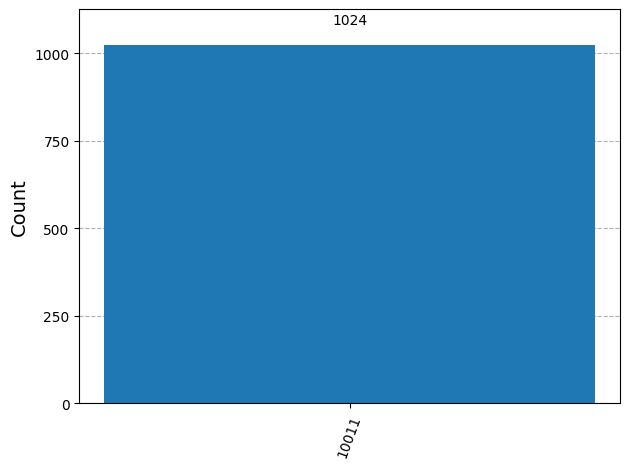

In [76]:
from qiskit.visualization import plot_histogram

plot_histogram(data=counts) #시뮬레이터에서 수행된 이상치 결과를 확인, 출력순서 MSB->LSB(10011)

**8.실제 QPU 환경세서 수행: 에러있는 실제값(확률) 확인**

In [70]:
#qpubackend = provider.get_backend("Aria 1")
#qpubackend = provider.get_backend("Aria 2")
#qpubackend = provider.get_backend("Forte 1")
#qpubackend = provider.get_backend("Emerald")
#qpubackend= provider.get_backend("Ankaa-3")
#qpubackend = provider.get_backend("Aspen-M-3")
qpubackend = provider.get_backend("Garnet")

In [61]:
trans_qc = transpile(circuit, qpubackend)
trans_qc.draw()

global phase: 3π/8
         ┌────────┐ ░                                                  »
q_0 -> 0 ┤ R(π,0) ├─░────────────────────────────────────■─────────────»
         └────────┘ ░    ┌──────────┐      ┌────────┐    │             »
q_4 -> 1 ───────────░────┤ R(-π,-π) ├──────┤ R(π,0) ├────┼─────────────»
                    ░ ┌──┴──────────┴──┐┌──┴────────┴──┐ │             »
q_2 -> 2 ───────────░─┤ R(-π/2,1.0209) ├┤ R(π,-2.6311) ├─┼─────────────»
                    ░ └─┬────────────┬─┘└──┬────────┬──┘ │ ┌──────────┐»
q_3 -> 3 ───────────░───┤ R(π/2,π/2) ├─────┤ R(π,0) ├────■─┤ R(-π,-π) ├»
         ┌────────┐ ░   └────────────┘     └────────┘      └──────────┘»
q_1 -> 4 ┤ R(π,0) ├─░──────────────────────────────────────────────────»
         └────────┘ ░                                                  »
    c: 5/══════════════════════════════════════════════════════════════»
                                                                       »
«                                                                      »
«q_0 -> 0 ─────────────────────────────────────────────────────────────»
«                                            ┌─────────────┐ ┌────────┐»
«q_4 -> 1 ─────────────────────────────────■─┤ R(-3π/4,-π) ├─┤ R(π,0) ├»
«                                          │ └─────────────┘ └────────┘»
«q_2 -> 2 ─────────────────────────────────┼─────────────────────■─────»
«         ┌────────┐   ┌─────────────────┐ │ ┌──────────────┐    │     »
«q_3 -> 3 ┤ R(π,0) ├─■─┤ R(-π/2,-2.5917) ├─┼─┤ R(π,-2.8667) ├────■─────»
«         └────────┘ │ └─────────────────┘ │ └──────────────┘          »
«q_1 -> 4 ───────────■─────────────────────■───────────────────────────»
«                                                                      »
«    c: 5/═════════════════════════════════════════════════════════════»
«                                                                      »
«                       ┌────────────────┐┌──────────────┐                   »
«q_0 -> 0 ──────■───────┤ R(-π/2,1.9949) ├┤ R(π,0.99744) ├───────────────────»
«               │       └─┬────────────┬─┘└─┬─────────┬──┘                   »
«q_4 -> 1 ──────■─────────┤ R(-3π/4,0) ├────┤ R(π,-π) ├────────────────────■─»
«         ┌────────────┐  ├───────────┬┘    └─────────┘   ┌──────────────┐ │ »
«q_2 -> 2 ┤ R(-π/2,-π) ├──┤ R(π,-π/4) ├──────────■────────┤ R(1.0209,-π) ├─┼─»
«         ├───────────┬┘  └┬──────────┤          │        ├──────────────┤ │ »
«q_3 -> 3 ┤ R(-π/2,0) ├────┤ R(π,π/4) ├──────────■────────┤ R(-π/2,-π/2) ├─┼─»
«         └───────────┘    └──────────┘                   └──────────────┘ │ »
«q_1 -> 4 ─────────────────────────────────────────────────────────────────■─»
«                                                                            »
«    c: 5/═══════════════════════════════════════════════════════════════════»
«                                                                            »
«                                                 ┌────────────┐┌───────────┐»
«q_0 -> 0 ──────────────────────────────────────■─┤ R(-π/2,-π) ├┤ R(π,-π/4) ├»
«         ┌────────────────────┐┌─────────────┐ │ ├───────────┬┘└┬──────────┤»
«q_4 -> 1 ┤ R(-0.87047,2.5733) ├┤ R(π,3.0527) ├─■─┤ R(-π/2,0) ├──┤ R(π,π/4) ├»
«         └────────────────────┘└─────────────┘   └───────────┘  └──────────┘»
«q_2 -> 2 ───────────────────────────────────────────────────────────────────»
«            ┌──────────────┐                                                »
«q_3 -> 3 ───┤ R(π,-1.8457) ├────────────────────────────────────────────────»
«           ┌┴──────────────┤    ┌───────────┐                               »
«q_1 -> 4 ──┤ R(-π/2,-3π/4) ├────┤ R(π,-π/8) ├───────────────────────────────»
«           └───────────────┘    └───────────┘                               »
«    c: 5/═══════════════════════════════════════════════════════════════════»
«                                                                            »
«            ┌───────────────

In [62]:
qpujob = qpubackend.run(trans_qc, shots=1024)

print("Job ID is", qpujob.job_id(),"\n")

/usr/local/lib/python3.12/dist-packages/qiskit_braket_provider/providers/adapter.py:593: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn("The Qiskit circuit contains barrier instructions that are ignored.")
/usr/local/lib/python3.12/dist-packages/qiskit_braket_provider/providers/adapter.py:643: UserWarning: Device does not support global phase; global phase of 1.1780972450961933 will not be included in Braket circuit
  warnings.warn(


Job ID is arn:aws:braket:eu-north-1:772420518916:quantum-task/79c4fa5f-a2dc-4290-b3c5-72d84c2a678c 



In [63]:
print("Job status is", qpujob.status() )

Job status is JobStatus.QUEUED


In [64]:
qpuresult = qpujob.result()
qpuresult

Result(backend_name='Garnet', backend_version='2', job_id='arn:aws:braket:eu-north-1:772420518916:quantum-task/79c4fa5f-a2dc-4290-b3c5-72d84c2a678c', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'11001': 596, '11101': 57, '00001': 15, '11000': 107, '01001': 37, '11100': 20, '01101': 20, '11011': 12, '00000': 15, '11010': 3, '01000': 58, '10000': 22, '10101': 6, '10001': 32, '10010': 2, '01100': 11, '10100': 1, '01010': 2, '11111': 3, '01011': 2, '10111': 1, '00100': 1, '10011': 1}, memory=['11001', '11101', '11001', '11001', '00001', '11000', '01001', '11101', '11001', '11101', '11001', '11100', '01101', '11001', '11011', '11001', '00000', '11001', '11010', '11001', '11001', '11001', '11001', '11001', '11001', '11101', '11001', '01000', '11000', '11001', '11001', '11001', '10000', '01000', '01001', '11001', '11001', '01001', '01000', '11001', '11001', '11001', '11000', '11000', '11000', '11001', '11001', '11001', '111

In [83]:
# 결과 출력
qpucounts = qpuresult.get_counts()
print(qpucounts)

{'11001': 596, '11101': 57, '00001': 15, '11000': 107, '01001': 37, '11100': 20, '01101': 20, '11011': 12, '00000': 15, '11010': 3, '01000': 58, '10000': 22, '10101': 6, '10001': 32, '10010': 2, '01100': 11, '10100': 1, '01010': 2, '11111': 3, '01011': 2, '10111': 1, '00100': 1, '10011': 1}


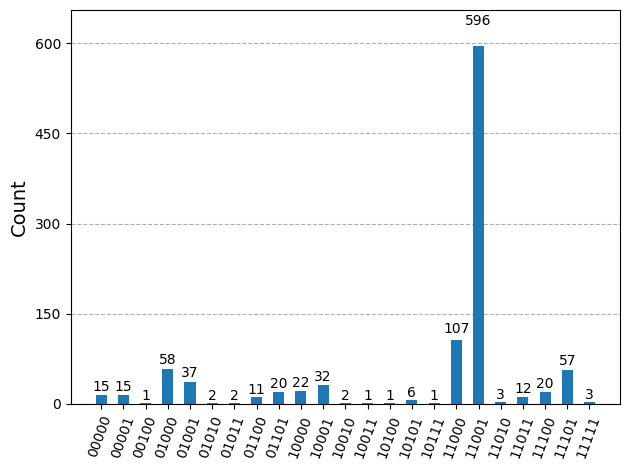

In [87]:
plot_histogram(data=qpucounts) #출력이 LSB->MSB(11001)순으로 나옴, 시뮬레이터와 QPU마다 차이가 남

** 시뮬레이터 이상치와 QPU 실측지의 비교"

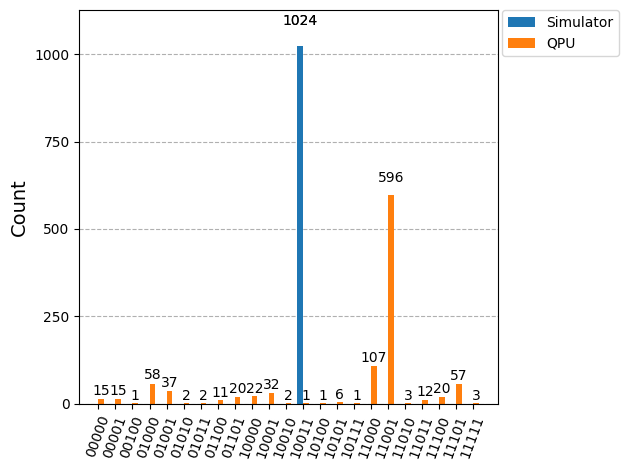

In [88]:
plot_histogram([counts, qpucounts], legend=['Simulator', 'QPU'])

In [68]:
print("Quantum Task Summary\n")
print(t.quantum_tasks_statistics())
print('\nNote: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. \nEstimated charges shown may differ from your actual charges. \nEstimated charges do not factor in any discounts or credits, \nand you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"\nEstimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

Quantum Task Summary

{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 2048, 'tasks': {'COMPLETED': 2}, 'execution_duration': datetime.timedelta(microseconds=144000), 'billed_execution_duration': datetime.timedelta(seconds=6)}, 'arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet': {'shots': 3072, 'tasks': {'COMPLETED': 3}}}

Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. 
Estimated charges shown may differ from your actual charges. 
Estimated charges do not factor in any discounts or credits, 
and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).

Estimated cost to run this example: 5.36 USD


Original qpucounts (LSB->MSB): {'11001': 596, '11101': 57, '00001': 15, '11000': 107, '01001': 37, '11100': 20, '01101': 20, '11011': 12, '00000': 15, '11010': 3, '01000': 58, '10000': 22, '10101': 6, '10001': 32, '10010': 2, '01100': 11, '10100': 1, '01010': 2, '11111': 3, '01011': 2, '10111': 1, '00100': 1, '10011': 1}
Reversed qpucounts (MSB->LSB): {'10011': 596, '10111': 57, '10000': 15, '00011': 107, '10010': 37, '00111': 20, '10110': 20, '11011': 12, '00000': 15, '01011': 3, '00010': 58, '00001': 22, '10101': 6, '10001': 32, '01001': 2, '00110': 11, '00101': 1, '01010': 2, '11111': 3, '11010': 2, '11101': 1, '00100': 1, '11001': 1}


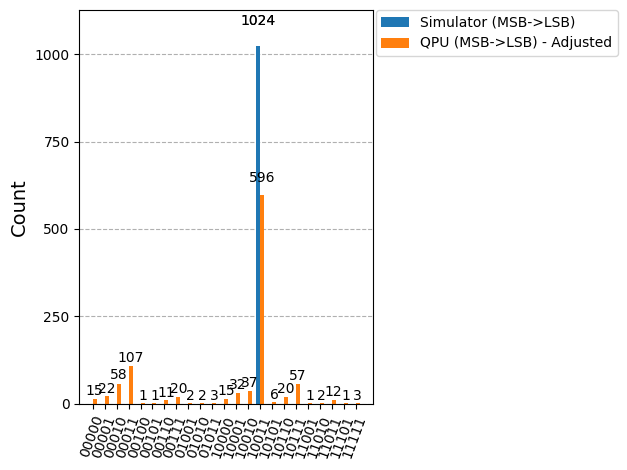

In [90]:
def reverse_bit_string_keys(counts_dict):
    """
    Reverses the bit string keys in a dictionary.
    Assumes keys are strings representing bit sequences.
    """
    reversed_counts = {}
    for key, value in counts_dict.items():
        reversed_key = key[::-1]  # Reverse the string
        reversed_counts[reversed_key] = value
    return reversed_counts

# qpucounts의 키를 뒤집어 MSB->LSB 순서로 맞춤
reversed_qpucounts = reverse_bit_string_keys(qpucounts)

print("Original qpucounts (LSB->MSB):", qpucounts)
print("Reversed qpucounts (MSB->LSB):", reversed_qpucounts)

# 일관된 순서로 히스토그램 플로팅
from qiskit.visualization import plot_histogram
plot_histogram([counts, reversed_qpucounts], legend=['Simulator (MSB->LSB)', 'QPU (MSB->LSB) - Adjusted'])